## OLS Model

In [1]:
## Laading libraries
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.patches as mpatches
from scipy.optimize import minimize
from pandas_datareader import DataReader
from datetime import datetime
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
# # 2019 stock data for P&G from Yahoo:
# PG = DataReader('PG',  'yahoo', datetime(2019,1,1), datetime(2019,12,31));

# # # Avergae of opening and closing:
# PG["Average"] = (PG["Open"] + 2*PG["High"] + PG["Close"])/4
# PG["Days"] = range(1,PG.shape[0]+1)

# # Required Dataset: 
# print(PG.shape)
# print(PG.head())

In [3]:
# loading dataset
def getData(strt_date, end_date):
    FF = pd.read_csv("C:\\Users\\sshai\\Desktop\\Northeastern University\\INFO 7374 ML In Finance\\INFO-7374-Machine-Learning-in-Finance\\Dashboard\\Shaishav\\fulldata.csv")
    # Date format change
    FF["Date"] = pd.to_datetime(FF["Date"])
    # Data selection
    df = FF[(FF["Date"] >= strt_date) & (FF["Date"] <= end_date)]
    # Reset Index
    df = df.reset_index()
    df = df.drop(["index"], axis =1)
    # Average Column and no. of days calculations
    df["Average"] = (FF["Open"] + 2*FF["High"] + FF["Close"])/4
    df["Days"] = range(1,df.shape[0]+1)
    df["beta_0"] = 1
    return df

In [4]:
def variable_correlation(df):
    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(df.corr(), center=0, cmap="BrBG", annot=True)

In [5]:
def beta_values(df, colm):
    x_t = np.array(df[colm].shift(periods=-1).dropna())
    y_t = np.array(df[["Open"]].shift(periods=1).dropna())
    b_t = np.matmul(np.matmul(np.linalg.inv(np.matmul(x_t.T,x_t)),x_t.T),y_t)
    b_t = b_t.tolist()
    b_t = [item for sublist in b_t for item in sublist]
    return b_t

In [6]:
def beta_coff(beta, df, colm, error):
    df_beta = pd.DataFrame(list(zip(colm, beta)), columns = ["Variables","Beta_Coeff"])
    n = len(df["Open"][:-1])
    SE_Coff = list()
    t = list()
    for i in colm:
        SSE = residual_variance(error)
        x_act = df[i][:-1]
        n1 = len(df[i][:-1])
        x_mean = sum(df[i])/n1
        res = list(x_act - x_mean)
        X = sum(map(lambda i : i * i, res))
        SE = sqrt(SSE/(n-2))/sqrt(X)
        SE_Coff.append(SE)
    df_beta["SE_Coff"] = SE_Coff
    df_beta["T-Value"] = df_beta['Beta_Coeff']/df_beta["SE_Coff"]
    df_beta["P-Value"] = stats.t.sf(abs(df_beta["T-Value"]),n-2)*2
    df_beta = df_beta.sort_values(by=['Beta_Coeff'], ascending=False) 
    return df_beta

In [14]:

def predictions(beta, df, colm):
    x_t = np.array(df[colm].shift(periods=-1).dropna())
    b_t = beta
    y_pred = np.matmul(x_t,b_t)
    return y_pred

In [7]:
def error_cal(ypred,df):
    y_pred = ypred
    y_act = df['Open'][:-1]
    error = list(y_act - y_pred)
#     abc = pd.DataFrame(list(zip(y_pred,y_act,error)))
#     print(abc)
    return error

In [8]:
def residual_variance(error):
    SSE = sum(map(lambda i : i * i, error)) 
    return SSE    

In [9]:
def totalError_Square(df):
    y_act = df['Open'][:-1]
    n = len(df["Open"][:-1])
    y_mean = sum(df["Open"])/n
    res = list(y_act - y_mean)
    SST = sum(map(lambda i : i * i, res))
    return SST

In [10]:
def R_squared(error, df):
    SSE = residual_variance(error)
    SST = totalError_Square(df)
    r2 = 1 - float(SSE/SST)
    return r2 

In [11]:
def rmse_value(error):
    SSE = residual_variance(error)
    n = len(error)
    rmse = sqrt(SSE/n)
    return rmse

In [12]:
def f_value(ypred, df, colm, error):
    k = len(colm) 
    y_act = df['Open'][:-1]
    n = len(df["Open"][:-1])
    y_mean = sum(df["Open"])/n
    y_pred = ypred
    res = list(y_pred - y_mean)
    SSR = sum(map(lambda i : i * i, res))
    SSE = residual_variance(error)
    F = (SSR/k)/(SSE/(n-k-1))
    return F

In [15]:
## User input, can be changed
strt_date = "2019-01-01"
end_date = "2019-08-31"

## final dataset
df_main = getData(strt_date, end_date)
# print(df_main.head())
# print(df_main.shape)
# plt.scatter(df_main["Days"],df_main["Open"])

## EDA
# variable_correlation(df_main)


## Variable selection for OLS:
colm = ['beta_0','RF', 'RMW', 'Days', "Average","Volume","SMB","Mkt-RF","HML","CMA"]
# colm = ['beta_0', 'Average','CMA', "HML", "Days"]

## Calculating beta_values:
b_t = beta_values(df_main, colm)

# Calculating Error using beta values found
y_pred = predictions(b_t, df_main, colm)
e = error_cal(y_pred, df_main)

# Statistics on Beta-coefficient:
df_beta = beta_coff(b_t, df_main, colm, e)
print(df_beta)

# Calculating accuracy estimators:
r2 = R_squared(e, df_main)
rmse = rmse_value(e)
fvalue = f_value(y_pred, df_main, colm, e)
print("R_2 value: ",r2)
print("rmse value: ",rmse)
print("F-Value: ",fvalue)

  Variables    Beta_Coeff       SE_Coff    T-Value        P-Value
0    beta_0  9.527950e+01  2.115825e+01   4.503185   1.260922e-05
6       SMB  5.428704e-01  2.597811e-01   2.089723   3.817653e-02
2       RMW  4.900943e-01  3.808667e-01   1.286787   1.999710e-01
3      Days  1.537298e-01  2.627548e-03  58.506948  2.945158e-112
8       HML  5.429917e-02  2.266595e-01   0.239563   8.109666e-01
5    Volume  1.574953e-09  3.876304e-08   0.040630   9.676398e-01
4   Average -4.940634e-02  1.356236e-02  -3.642902   3.606674e-04
7    Mkt-RF -4.515815e-01  1.388963e-01  -3.251214   1.393205e-03
9       CMA -1.133503e+00  4.174260e-01  -2.715458   7.323133e-03
1        RF -1.154689e+02  1.368527e+02  -0.843746   4.000330e-01
R_2 value:  0.9591578294704839
rmse value:  1.6274407004260094
F-Value:  366.3581525112093


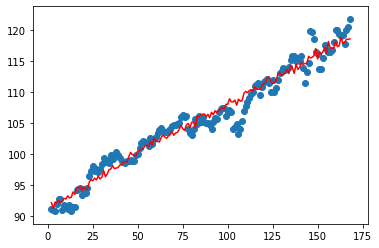

In [16]:
# PLotting graph of y_pred vs y_act:
x = df_main["Days"][1:]
y = df_main["Open"][:-1]
plt.plot(x, y_pred, '-r')
plt.scatter(x,y)

### Still working

In [ ]:
## Calculating values for next 5 months based on Beta values obtained:
## User input, can be changed
strt_date = "2018-08-01"
end_date = "2018-08-31"
df = getData(strt_date, end_date)

# print(df_main.head())
print(df.shape)
colm = ['beta_0','RF', 'RMW', 'Days', "Average","Volume","SMB","Mkt-RF","HML","CMA"]
colm = ['beta_0', 'Average','CMA', "HML", "Days"]
print(b_t)

y_pred = predictions(b_t, df, colm)
e = error_cal(y_pred, df)

# Calculating accuracy estimators:
r2 = R_squared(e, df)
rmse = rmse_value(e)
print("R_2 value: ",r2)
print("rmse value: ",rmse)

In [ ]:
# PLotting graph of y_pred vs y_act:
x = df["Days"][1:]
y = df["Open"][:-1]
plt.plot(x, y_pred, '-r')
plt.scatter(x,y)